In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torchvision import transforms

import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [3]:
class Params:
  class_num = 10
  batch_size = 16
  learning_rate = 0.001
  dropout = 0.5
  momentum = 0.9
  epochs = 1000


In [4]:
class AddPepperNoise(object):
    """add pepper noise
    Args:
        snr （float）: Signal Noise Rate
        p (float): probability
    """

    def __init__(self, snr, p=0.9):
        assert isinstance(snr, float) or (isinstance(p, float))
        self.snr = snr
        self.p = p

    def __call__(self, img):
        """
        Args:
            img (PIL Image): PIL Image
        Returns:
            PIL Image: PIL image.
        """
        if random.uniform(0, 1) < self.p:
            img_ = np.array(img).copy()
            h, w = img_.shape
            signal_pct = self.snr
            noise_pct = (1 - self.snr)
            mask = np.random.choice((0, 1, 2), size=(h, w), p=[signal_pct, noise_pct/2., noise_pct/2.])
            img_[mask == 1] = 255   # 盐噪声
            img_[mask == 2] = 0     # 椒噪声
            return Image.fromarray(img_.astype('uint8')).convert('L')
        else:
            return img

In [5]:
base_path = "leapGestRecog/"
people = ["00", "01", "02", "03", "04", "05", "06", "07", "08", "09"]
gestures = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10"]
gestures_map = {
    1: "palm", 
    2: "l", 
    3: "fist", 
    4: "fist_moved",
    5: "thumb", 
    6: "index", 
    7: "ok", 
    8: "palm_moved", 
    9: "c",
    10: "down"
}

can_transform = [1, 3, 4, 6, 7, 8]

train_can_transform = transforms.Compose([
  # transforms.RandomHorizontalFlip(),
  # transforms.RandomVerticalFlip(),
  # transforms.RandomRotation(45),
  # AddPepperNoise(0.9, p=0.5),
  transforms.ToTensor()
])

train_cant_transform = transforms.Compose([
  # AddPepperNoise(0.9, p=0.5),
  transforms.ToTensor()
])

other_transform = transforms.Compose([
  transforms.ToTensor()
])

class GestureDataset(Dataset):
  def __init__(self, is_train=True):
    img_labels = []
    for person in range(10):
      for label in range(1, 11):
        path = "%s/%s_%s/" % (str(person).zfill(2), str(label).zfill(2), gestures_map[label])
        for id in range(1, 201):
          filename = "frame_%s_%s_%s.png" % (str(person).zfill(2), str(label).zfill(2), str(id).zfill(4))
          img_labels.append((base_path + path + filename, label))
          
    self.img_labels = img_labels 
    self.is_train = is_train
  def __getitem__(self, index):
    path, label = self.img_labels[index]
    img = Image.open(path).convert('L') # convert to black and white

    if self.is_train:
      if label in can_transform:
        img = train_can_transform(img)
      else:
        img = train_cant_transform(img)
    else:
      img = other_transform(img)

    return img, label - 1
  def __len__(self):
    return len(self.img_labels)

In [6]:
gesture_dataset = GestureDataset()

train_size = int(20000*0.8)
test_size = int(20000*0.2)

train_dataset, test_dataset = torch.utils.data.random_split(gesture_dataset, [train_size, test_size])
test_dataset.is_train = False

In [7]:
class Model(nn.Module):
  def __init__(self, dropout):
    super(Model, self).__init__()
    self.conv1 = nn.Conv2d(1,12, kernel_size=5, stride=1, padding=0)
    self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.conv2 = nn.Conv2d(12, 16, kernel_size=5, stride=1, padding=0)
    self.conv2_drop = nn.Dropout2d(p=dropout)
    self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    self.fc1 = nn.Linear(143184, 512) # number channels * width * height
    self.fc2 = nn.Linear(512, 10)
    self.fc1_drop = nn.Dropout(p=dropout)

  def forward(self, x):
    # print(x.size(0))
    # print(x.shape)
    x = torch.relu(self.max_pool1(self.conv1(x)))
    # print(x.shape)
    x = torch.relu(self.max_pool2(self.conv2_drop(self.conv2(x))))
    
    # flatten over channel, height and width
    # print(x.shape)
    x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
    
    x = torch.relu(self.fc1_drop(self.fc1(x)))
    # x = torch.softmax(self.fc2(x), dim=-1)
    x = torch.relu(self.fc2(x))
    return x


model = Model(dropout=Params.dropout).to(device)

In [8]:

history = {
  "loss": [],
  "acc": [],
  "loss_iter": [],
  "val_loss": [],
  "val_acc": []
}

test_res = {
  "loss": 0,
  "acc": 0
}

def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.train()
  epoch_loss, epoch_acc = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    # print(pred.argmax(1))
    loss = loss_fn(pred, y)
  
    history["loss_iter"].append(loss.item())
    epoch_loss += loss.item()
    epoch_acc += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
  
  epoch_loss /= num_batches
  epoch_acc /= size
  print(f"Training: \n Accuracy: {(100*epoch_acc):>0.2f}%, Avg loss: {epoch_loss:>8f}")
  history["loss"].append(epoch_loss)
  history["acc"].append(epoch_acc)

def validate(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  val_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      val_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  val_loss /= num_batches
  correct /= size
  history["val_loss"].append(val_loss)
  history["val_acc"].append(correct)
  print(f"Validation: \n Accuracy: {(100*correct):>0.2f}%, Avg loss: {val_loss:>8f}")

def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  test_res["loss"] = test_loss
  test_res["acc"] = correct
  print(f"Test Error: \n Accuracy: {(100*correct):>0.2f}%, Avg loss: {test_loss:>8f} \n")

In [9]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''
        Saves model when validation loss decrease.
        '''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...\n')
        # torch.save(model.state_dict(), 'checkpoint.pt')
        # torch.save(model, 'finish_model.pkl')
        self.val_loss_min = val_loss

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=Params.learning_rate, momentum=Params.momentum)

early_stopping = EarlyStopping(patience=3, verbose=True, delta=1e-4)
stop_epoch = Params.epochs

for t in range(Params.epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_size = int(20000*0.7)
  val_size = int(20000*0.1)

  _, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
  val_dataset.is_train = False

  train_dataloader = DataLoader(train_dataset, batch_size=Params.batch_size, shuffle=True, num_workers=2, pin_memory=True)
  val_dataloader = DataLoader(val_dataset, batch_size=Params.batch_size, shuffle=True, num_workers=2, pin_memory=True)
  train(train_dataloader, model, loss_fn, optimizer)
  validate(val_dataloader, model, loss_fn)

  val_loss = history["val_loss"][-1]
  early_stopping(val_loss, model)

  if early_stopping.early_stop:
    stop_epoch = t + 1
    print(f"Early stopping at {t + 1}")
    break

print("Done!")


Epoch 1
-------------------------------
loss: 2.303844  [    0/16000]
loss: 2.338764  [ 1600/16000]
loss: 1.807695  [ 3200/16000]
loss: 1.635547  [ 4800/16000]
loss: 1.607469  [ 6400/16000]
loss: 0.939426  [ 8000/16000]
loss: 0.718058  [ 9600/16000]
loss: 0.943810  [11200/16000]
loss: 0.511498  [12800/16000]
loss: 1.062936  [14400/16000]
Training: 
 Accuracy: 53.29%, Avg loss: 1.372584
Validation: 
 Accuracy: 92.65%, Avg loss: 0.265313
Validation loss decreased (inf --> 0.265313).  Saving model ...

Epoch 2
-------------------------------
loss: 0.636735  [    0/16000]
loss: 0.446164  [ 1600/16000]
loss: 0.281829  [ 3200/16000]
loss: 0.503872  [ 4800/16000]
loss: 0.311919  [ 6400/16000]
loss: 0.063846  [ 8000/16000]
loss: 0.264429  [ 9600/16000]
loss: 0.376614  [11200/16000]
loss: 0.228457  [12800/16000]
loss: 0.220041  [14400/16000]
Training: 
 Accuracy: 87.19%, Avg loss: 0.401797
Validation: 
 Accuracy: 98.30%, Avg loss: 0.064467
Validation loss decreased (0.265313 --> 0.064467).  Sav

In [11]:
test_dataloader = DataLoader(test_dataset, batch_size=Params.batch_size, shuffle=True, num_workers=2, pin_memory=True)
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 99.95%, Avg loss: 0.004932 



In [12]:
# 保存
# torch.save(model, 'model.pkl')
# 加载
# model = torch.load('\model.pkl')

Feature batch shape: torch.Size([16, 1, 240, 640])
Labels batch shape: torch.Size([16])


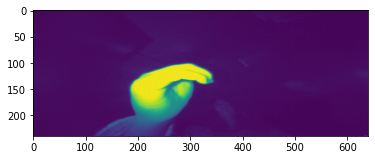

Label: 8


In [13]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

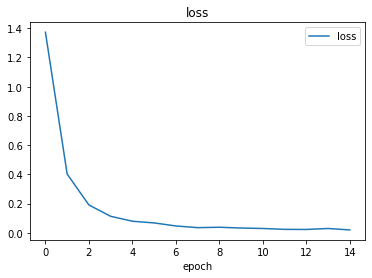

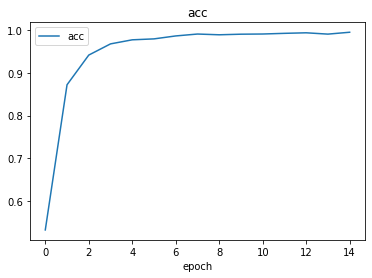

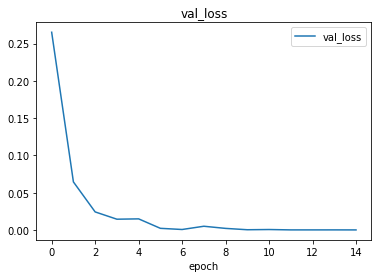

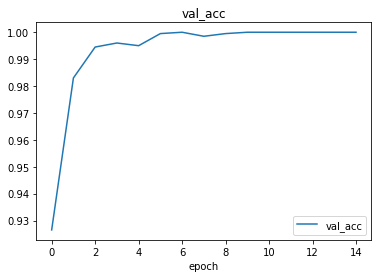

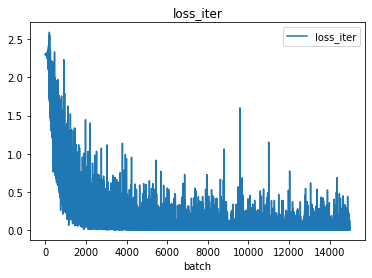

In [14]:
fig = plt.figure()  # 新建一张图
plt.plot(history['loss'], label="loss")
plt.title('loss')
# plt.ylabel(attr)
plt.xlabel('epoch')
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(history['acc'], label="acc")
plt.title('acc')
# plt.ylabel(attr)
plt.xlabel('epoch')
plt.legend()
plt.show()

fig = plt.figure()
# plt.plot(history["loss"], label='training loss')
plt.plot(history['val_loss'], label="val_loss")
plt.title('val_loss')
# plt.ylabel(attr)
plt.xlabel('epoch')
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(history['val_acc'], label="val_acc")
plt.title('val_acc')
# plt.ylabel(attr)
plt.xlabel('epoch')
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(history['loss_iter'], label="loss_iter")
plt.title('loss_iter')
# plt.ylabel(attr)
plt.xlabel('batch')
plt.legend()
plt.show()

In [15]:
import json

res = dict()
res["params"] = dict()
res["params"]["batch_size"] = Params.batch_size
res["params"]["learning_rate"] = Params.learning_rate
res["params"]["dropout"] = Params.dropout
res["params"]["momentum"] = Params.momentum
res["params"]["epochs"] = stop_epoch
res["history"] = history
res["test"] = test_res

# print(res)

with open('res.json','w') as outfile:
    json.dump(res, outfile, ensure_ascii=False)
    outfile.write('\n')